# Scraping Companies Information for listed  companies  on Ycombinator

<br>
<br>
<br>

# Project Outline
1. To start with, I'm going to scrape about 1000 entries from https://ycombinator.com/companies, which are:
- The listed company names
- The company's ycombinator page url 
- The company location (will prefer to get it here since it is written with the country, unlike how it appeared when the company name has been clicked
- The company description head/slogan. Then,


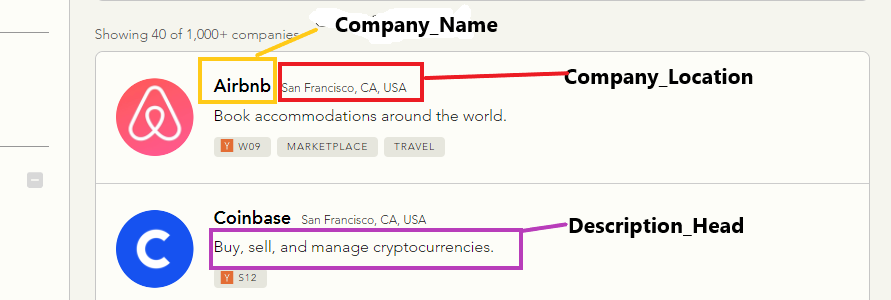

<br>
<br>
<br>

2. I'll go through the scraped company's ycombinator page url  and grab many other informations (company's description, year founded, team size, company page url, social media urls, management details) as they appear on the page.

3. At the end, I will create for each company, a CSV file in the following format:

```
'Company_Name'| 'Company_Page_URL'| 'Company_Location'| 'Description_Head'| 'Website'| 'Description'| 'Founded'| 'Team_Size'| 'Linkedin_Profile'| 'Twitter_Profile'| 'Facebook_Profile'| 'Crunchbase_Profile'| 'Active_Founder1'| 'Active_Founder2'| 'Active_Founder3'
Airbnb|	https://www.ycombinator.com/companies/airbnb|	San Francisco, CA, US,|	Book accommodations around the world.|  http://airbnb.com | Founded in August of 2008 and based in San Fra... | 2008 | 5000 | https://www.linkedin.com/company/airbnb/ | https://twitter.com/Airbnb | https://www.facebook.com/airbnb/ | https://www.crunchbase.com/organization/airbnb | Nathan Blecharczyk\nNone\nhttps://twitter.com/... | Brian Chesky\nNone\nhttps://twitter.com/bchesky\n | Joe Gebbia\nNone\nhttps://twitter.com/jgebbia\n,```


## Scrape the list of companies from ycomobinator

- use **selenium** to downlaod the page
- use **BS4** to parse and extract information
- convert to a Pandas dataframe

lets import the necessary packages

In [267]:
# import necessary modules
import time

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait


import pandas as pd
import numpy as np

In [78]:
def chrome(mode='h'):

    ''' A function to instantiate chrome driver

        :arguments: 
            mode - representing either headless (preferred) or browser mode.
        :returns: 
            driver - the driver object instantiated.
    '''

    if mode == 'h':
        #  Headless mode
        chrome_option = Options()
        chrome_option.add_argument("--headless")
        chrome_option.add_argument("--log-level=3")     # disabling unwanted messages printed while running with am headless browser
        driver = webdriver.Chrome(options=chrome_option)

    elif mode == 'b':
        # Browser mode
        driver = webdriver.Chrome()

    else:
        print("Mode is invalid")
        return None

    return driver



def get_ycombinator_page(page_url=None, browser=None):
    """
    A function to get the page source codes and contents

        :arguments: 
            page_url - the url for of the page
            browser - the webdriver object
        :returns: 
            page_dom - a beautiful soup object of the page contents.
    """
    
    time.sleep(5)
    browser.get(url)
    time.sleep(20) # allow the page to load 
    
    
    ################ implement infinite scrolling ######################################
    previous_height = browser.execute_script('return document.body.scrollHeight')

    i = 0
    while True:
        i+=1
        print("scroll: ", i)

        browser.execute_script('window.scrollTo(0,document.body.scrollHeight)')

        time.sleep(3)

        new_height = browser.execute_script('return document.body.scrollHeight')

        if previous_height == new_height:
            print("End of page reached")
            break

        previous_height = new_height
    ################################################################################
    
    time.sleep(5)

    file = browser.page_source
    page_dom = BeautifulSoup(file,"html.parser")
    
    return page_dom





def get_company_page_info(doc):
    """
    A function to get the names of startup companies, location and url of company pages on ycombinator

        :arguments: 
            doc - the bs4 object of the ycombinator page
        :returns: 
            DataFrame object of the data collected
    """
    page_dict = { 'Company_Name': [], 'Company_Page_URL': [], 'Company_Location': [], 'Description_Head': []}

    # find all a tags with class name "styles-module__company___1UVnl no-hovercard" which points to individual company segment
    item = soup.find_all("a",{"class":"styles-module__company___1UVnl no-hovercard"})
    
    
    # get page informations
    for i in range(len(item)):
        # company name
        company_name = item[i].find('span', {"class":"styles-module__coName___3zz21"})
        page_dict["Company_Name"].append(company_name.text)
        
        # company page url
        company_page_url = item[i]['href']
        page_dict["Company_Page_URL"].append("https://www.ycombinator.com"+company_page_url)    

        # company location
        company_location = item[i].find('span', {"class":"styles-module__coLocation___yhKam"})
        page_dict["Company_Location"].append(company_location.text)
        
        # Description_Head
        description_head = item[i].find('span', {"class":"styles-module__coDescription___1b_yd"})
        page_dict["Description_Head"].append(description_head.text)


        
    return pd.DataFrame(page_dict)

Call the functions to perform the first outline:

In [30]:
url = " https://ycombinator.com/companies"

driver = chrome("b")  # instantiate the webdriver
doc = get_ycombinator_page(page_url=url, browser = driver)
df = get_company_name_and_page_url(doc)

scroll:  1
scroll:  2
scroll:  3
scroll:  4
scroll:  5
scroll:  6
scroll:  7
scroll:  8
scroll:  9
scroll:  10
scroll:  11
scroll:  12
scroll:  13
scroll:  14
scroll:  15
scroll:  16
scroll:  17
scroll:  18
scroll:  19
scroll:  20
scroll:  21
scroll:  22
scroll:  23
scroll:  24
scroll:  25
scroll:  26
scroll:  27
scroll:  28
scroll:  29
scroll:  30
scroll:  31
scroll:  32
scroll:  33
scroll:  34
scroll:  35
scroll:  36
scroll:  37
scroll:  38
scroll:  39
scroll:  40
scroll:  41
scroll:  42
scroll:  43
scroll:  44
scroll:  45
scroll:  46
scroll:  47
scroll:  48
scroll:  49
End of page reached


In [268]:
df.tail()

,Company_Name,Company_Page_URL,Company_Location,Description_Head
995,Pylon,https://www.ycombinator.com/companies/pylon,"Cairo, Cairo Governorate, Egypt",Infrastructure management software for water &...
996,Dime,https://www.ycombinator.com/companies/dime,"San Francisco, CA, USA",Turn your content into unique digital collecti...
997,Telivy,https://www.ycombinator.com/companies/telivy,"San Francisco, CA, USA",Fastest way to purchase cyber insurance for sm...
998,Zuma,https://www.ycombinator.com/companies/resident...,"San Francisco, CA, USA",We help businesses convert leads into sales in...
999,PAYZE,https://www.ycombinator.com/companies/payze,"Tbilisi, Georgia",Stripe for former Soviet Union countries


Save outline 1 to a csv:

In [77]:
print(df.info())

print(df.head())

df.to_csv("ycombinator_info.csv", index= False )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Company_Name      1000 non-null   object
 1   Company_Page_URL  1000 non-null   object
 2   Company_Location  1000 non-null   object
 3   Description_Head  1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB
None
  Company_Name                                Company_Page_URL  \
0       Airbnb    https://www.ycombinator.com/companies/airbnb   
1     Coinbase  https://www.ycombinator.com/companies/coinbase   
2     DoorDash  https://www.ycombinator.com/companies/doordash   
3       GitLab    https://www.ycombinator.com/companies/gitlab   
4      Dropbox   https://www.ycombinator.com/companies/dropbox   

         Company_Location                                   Description_Head  
0  San Francisco, CA, USA              Book accommodations around the world.  
1  San Francisco, 


## Now, I will write functions to :


1. Browse each Company_Page_URL 
2. Get actual company website address
3. Get the company description as appeared on ycombinator
4. Get the company year founded and team size,
5. Get the company social media urls
6. Get the company founder infos such as there name, position and social media urls
7. Then after collecting the above info for all Company_Page_URL, create a CSV from concatenating the earlier scraped df with the dataframe of the newly collected infos



In [277]:
def get_company_website(doc):
    # scrape the websites
    try:
        company_websites_tags = doc.find("a",{"target":"_blank"})
        try:
            company_websites = company_websites_tags.text
        except:
            company_websites = company_websites_tags
    except:
        company_websites = np.nan
    return company_websites



def get_company_description(doc):
    # scrape the descriptions
    try:
        company_description_tags = doc.find("p",{"class":"whitespace-pre-line"})
        try:
            company_description = company_description_tags.text
        except:
            company_description = company_description_tags
    except:
        company_description = np.nan
    return company_description



def get_company_year_founded_and_team_size(doc):

    # scrape
    try:
        ppty = doc.find("div",{"class":"space-y-0.5"}).find_all("div",{"class":"flex flex-row justify-between"})
        year_founded = ppty[0].text.split(":")[1]
        team_size = ppty[1].text.split(":")[1]
        
        company_year = year_founded
        company_size = team_size
    except:
        company_year = np.nan
        company_size = np.nan

    return company_year, company_size


        
def get_company_social_media_urls(doc):

    # scrape the social network urls
    try:
        
        sm_info = doc.find("div",{"class":"space-x-2"})
        
        try:
            linkedin_url = sm_info.find("a",{"title":"LinkedIn profile"})["href"]
        except:
            linkedin_url = np.NaN     
        try:
            twitter_url = sm_info.find("a",{"title":"Twitter account"})["href"]
        except:
            twitter_url = np.NaN    
        try:
            facebook_url = sm_info.find("a",{"title":"Facebook profile"})["href"]
        except:
            facebook_url = np.NaN
        try:
            crunchbase_url = sm_info.find("a",{"title":"Crunchbase profile"})["href"]
        except:
            crunchbase_url = np.NaN

    except:
        linkedin_url = np.NaN
        twitter_url = np.NaN    
        facebook_url = np.NaN
        crunchbase_url = np.NaN 

    return linkedin_url, twitter_url, facebook_url, crunchbase_url

        
def get_founder_info(doc):
    founder_dict = {}

    try:
        founder_info = doc.find_all("div",{"class":"leading-snug"})
    except:
        founder_info = ""
    

    if len(founder_info)>0:
        
        for i in range(len(founder_info)):

            founder_name = founder_info[i].find("div",{"class":"font-bold"}).text


            try:
                founder_post = founder_info[i].find("div",{"class":""}).text
            except:
                founder_post = founder_info[i].find("div",{"class":""})

            try:
                founder_sm = founder_info[i].find("div",{"class":"mt-1 space-x-2"}).find_all("a")
                founder_sm_links = ""
                for j in founder_sm:
                    founder_sm_links = founder_sm_links + str(j["href"]) + "\n"
            except:
                founder_sm_links = "None"

            founder = founder_name + "\n" + str(founder_post) + "\n"  + founder_sm_links # + "\n" + str(founder_descr) 

            founder_dict["Active_Founder"+str(i+1)] = founder

        return founder_dict
    
    
    else:
        return founder_dict

        
        
        
        

def scrape_all(url_list=None, driver=None, df=None):
    l = []
    for pointer,url in enumerate(url_list):
        driver.get(url)
        time.sleep(4)
        soup_other = BeautifulSoup(driver.page_source,"html.parser")
        
        c_web = get_company_website(soup_other)
        c_description = get_company_description(soup_other)
        company_year, company_size = get_company_year_founded_and_team_size(soup_other)
        linkedin_url, twitter_url, facebook_url, crunchbase_url = get_company_social_media_urls(soup_other)
        founder_details = get_founder_info(soup_other)
        
        
        d = {'Website': c_web,
             'Description': c_description,
             'Founded': company_year,
             'Team_Size': company_size,
             'Linkedin_Profile': linkedin_url,
             'Twitter_Profile': twitter_url,
             'Facebook_Profile': facebook_url,
             'Crunchbase_Profile': crunchbase_url,             
             }     
        
        d.update(founder_details)
        
        l.append(d)
        print("url list index %s is done!"%(pointer))
        
    other_df = pd.DataFrame(l)
    
    return pd.concat([df,other_df], axis=1)

Call the scrape all function

In [272]:
url_list = df["Company_Page_URL"].to_list()

time_start = time.time()

df_total = scrape_all(url_list=url_list, driver=driver, df=df)

time_used = time.time() - time_start

print("The time used is %s hours"%(time_used/3600))

url list index 0 is done!
url list index 1 is done!
url list index 2 is done!
url list index 3 is done!
url list index 4 is done!
url list index 5 is done!
url list index 6 is done!
url list index 7 is done!
url list index 8 is done!
url list index 9 is done!
url list index 10 is done!
url list index 11 is done!
url list index 12 is done!
url list index 13 is done!
url list index 14 is done!
url list index 15 is done!
url list index 16 is done!
url list index 17 is done!
url list index 18 is done!
url list index 19 is done!
url list index 20 is done!
url list index 21 is done!
url list index 22 is done!
url list index 23 is done!
url list index 24 is done!
url list index 25 is done!
url list index 26 is done!
url list index 27 is done!
url list index 28 is done!
url list index 29 is done!
url list index 30 is done!
url list index 31 is done!
url list index 32 is done!
url list index 33 is done!
url list index 34 is done!
url list index 35 is done!
url list index 36 is done!
url list in

url list index 297 is done!
url list index 298 is done!
url list index 299 is done!
url list index 300 is done!
url list index 301 is done!
url list index 302 is done!
url list index 303 is done!
url list index 304 is done!
url list index 305 is done!
url list index 306 is done!
url list index 307 is done!
url list index 308 is done!
url list index 309 is done!
url list index 310 is done!
url list index 311 is done!
url list index 312 is done!
url list index 313 is done!
url list index 314 is done!
url list index 315 is done!
url list index 316 is done!
url list index 317 is done!
url list index 318 is done!
url list index 319 is done!
url list index 320 is done!
url list index 321 is done!
url list index 322 is done!
url list index 323 is done!
url list index 324 is done!
url list index 325 is done!
url list index 326 is done!
url list index 327 is done!
url list index 328 is done!
url list index 329 is done!
url list index 330 is done!
url list index 331 is done!
url list index 332 i

url list index 590 is done!
url list index 591 is done!
url list index 592 is done!
url list index 593 is done!
url list index 594 is done!
url list index 595 is done!
url list index 596 is done!
url list index 597 is done!
url list index 598 is done!
url list index 599 is done!
url list index 600 is done!
url list index 601 is done!
url list index 602 is done!
url list index 603 is done!
url list index 604 is done!
url list index 605 is done!
url list index 606 is done!
url list index 607 is done!
url list index 608 is done!
url list index 609 is done!
url list index 610 is done!
url list index 611 is done!
url list index 612 is done!
url list index 613 is done!
url list index 614 is done!
url list index 615 is done!
url list index 616 is done!
url list index 617 is done!
url list index 618 is done!
url list index 619 is done!
url list index 620 is done!
url list index 621 is done!
url list index 622 is done!
url list index 623 is done!
url list index 624 is done!
url list index 625 i

WebDriverException: Message: unknown error: net::ERR_INTERNET_DISCONNECTED
  (Session info: chrome=99.0.4844.84)
Stacktrace:
Backtrace:
	Ordinal0 [0x00609943+2595139]
	Ordinal0 [0x0059C9F1+2148849]
	Ordinal0 [0x00494528+1066280]
	Ordinal0 [0x00490DB4+1052084]
	Ordinal0 [0x004863BD+1008573]
	Ordinal0 [0x00486F7C+1011580]
	Ordinal0 [0x004865CA+1009098]
	Ordinal0 [0x00485BC6+1006534]
	Ordinal0 [0x00484AD0+1002192]
	Ordinal0 [0x00484FAD+1003437]
	Ordinal0 [0x00495C4A+1072202]
	Ordinal0 [0x004EC19D+1425821]
	Ordinal0 [0x004DB9EC+1358316]
	Ordinal0 [0x004EBAF2+1424114]
	Ordinal0 [0x004DB806+1357830]
	Ordinal0 [0x004B6086+1204358]
	Ordinal0 [0x004B6F96+1208214]
	GetHandleVerifier [0x007AB232+1658114]
	GetHandleVerifier [0x0086312C+2411516]
	GetHandleVerifier [0x0069F261+560433]
	GetHandleVerifier [0x0069E366+556598]
	Ordinal0 [0x005A286B+2173035]
	Ordinal0 [0x005A75F8+2192888]
	Ordinal0 [0x005A76E5+2193125]
	Ordinal0 [0x005B11FC+2232828]
	BaseThreadInitThunk [0x7539FA29+25]
	RtlGetAppContainerNamedObjectPath [0x77617A9E+286]
	RtlGetAppContainerNamedObjectPath [0x77617A6E+238]


In [276]:
df_total.head(3)

,Company_Name,Company_Page_URL,Company_Location,Description_Head,Website,Description,Founded,Team_Size,Linkedin_Profile,Twitter_Profile,Facebook_Profile,Crunchbase_Profile,Active_Founder1,Active_Founder2,Active_Founder3
0,Airbnb,https://www.ycombinator.com/companies/airbnb,"San Francisco, CA, USA",Book accommodations around the world.,http://airbnb.com,Founded in August of 2008 and based in San Fra...,2008,5000,https://www.linkedin.com/company/airbnb/,https://twitter.com/Airbnb,https://www.facebook.com/airbnb/,https://www.crunchbase.com/organization/airbnb,Nathan Blecharczyk\nNone\nhttps://twitter.com/...,Brian Chesky\nNone\nhttps://twitter.com/bchesky\n,Joe Gebbia\nNone\nhttps://twitter.com/jgebbia\n
1,Coinbase,https://www.ycombinator.com/companies/coinbase,"San Francisco, CA, USA","Buy, sell, and manage cryptocurrencies.",https://www.coinbase.com,"Founded in June of 2012, Coinbase is a digital...",2012,500,NaN,https://twitter.com/coinbase,https://www.facebook.com/Coinbase/,https://www.crunchbase.com/organization/coinbase,Brian Armstrong\nCEO\nhttps://twitter.com/bria...,NaN,NaN
2,DoorDash,https://www.ycombinator.com/companies/doordash,"San Francisco, CA, USA",Restaurant delivery.,http://doordash.com,"Founded in 2013, DoorDash is a San Francisco-b...",,1600,https://www.linkedin.com/company/doordash/,http://twitter.com/doordash,https://www.facebook.com/DoorDash/,https://www.crunchbase.com/organization/doordash,Andy Fang\nFounder\n,Stanley Tang\nFounder\n,Tony Xu\nCEO\n


In [275]:
df_total.to_csv("final_result_template.csv", index = False)

# References and Future Work

### Summary of what I did / Issues
- I have just succesfully done all the outlined procedures from the begiining of the project. However, I made a terrible mistake from making my code into modules/functions. I wasn't considerate of network failure which resulted into the scraper not returning any dataframe in the case of a network failure.
- I hope with guidance and little more time, will be able to correct this error

### References

- How to make infinite scrolling with selenium [https://www.youtube.com/watch?v=qhJ_gMB772U]
 
### Ideas for future work

- Make the code robust to network failure